* Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.

In [235]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [236]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000,n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=2, random_state=5)

In [237]:
classification_data.shape

(1000, 2)

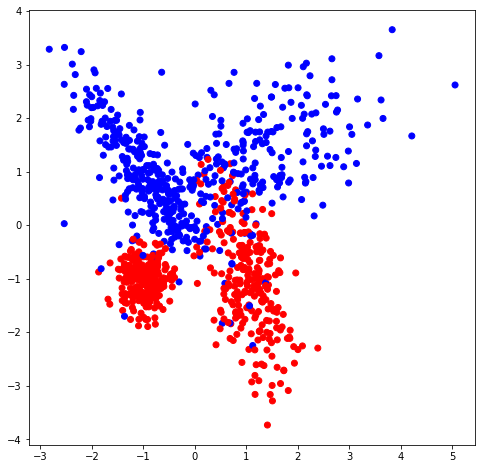

In [238]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [239]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
        self.max_depth = 1 # 0 - нет ограничений
        self.max_leaf = 5 # 0 - нет ограничений
        self.depth = 0
        self.leaf = 0

In [240]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction      

In [242]:
# Расчет дисперсии
import statistics
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    p = sum(labels) / len(labels)
    impurity = sum((label - p) ** 2 for label in labels) / len(labels)
        
    return impurity


In [243]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [244]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [245]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5
    
    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [246]:
# Построение дерева с помощью рекурсивной функции


def build_tree(data, labels, max_depth, max_leaf, depth, leaf):


    quality, t, index = find_best_split(data, labels)
    
    #  прекращаем рекурсию, когда достигнут предел по кол-ву листьев
    if leaf >= max_leaf and max_leaf != 0:
        return Leaf(data, labels)

    # прекращаем рекурсию, когда достигнут предел по глубине дерева
    if depth >= max_depth and max_depth !=0:
        return Leaf(data, labels)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)
    
    
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
   
    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth, max_leaf, depth+1, leaf+2)
    false_branch = build_tree(false_data, false_labels, max_depth, max_leaf, depth+1, leaf+2)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [247]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [248]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [249]:
from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)


In [250]:
print((train_data.shape), (test_data.shape))

(700, 2) (300, 2)


Здесь мы меняем глубину и кол-во листов

In [251]:
# Построим дерево по обучающей выборке
max_depth = 5
max_leaf = 40
depth = 0
leaf = 0
my_tree = build_tree(train_data, train_labels, max_depth, max_leaf, depth, leaf)


In [252]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс:', str(node.index))
    print(spacing + 'Порог:', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс: 1
Порог: -0.3142659126116033
--> True:
  Индекс: 1
  Порог: -0.5948838228187372
  --> True:
    Индекс: 0
    Порог: -1.3687153893767392
    --> True:
      Индекс: 0
      Порог: -1.415670659755537
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс: 1
      Порог: -1.5059771423719872
      --> True:
        Индекс: 1
        Порог: -1.539495584466808
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс: 0
    Порог: 0.4808547236335672
    --> True:
      Индекс: 1
      Порог: -0.48503863239579514
      --> True:
        Индекс: 1
        Порог: -0.5367633982219875
        --> True:
          Прогноз: 0
        --> False:
          Прогноз: 0
      --> False:
        Индекс: 1
        Порог: -0.44212542359663076
        --> True:
          Прогноз: 1
        --> False:
          Прогноз: 0
    --> False:
      Индекс: 0
      Порог: 1.1852575012

In [253]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [254]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [255]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [256]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

95.0

In [257]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

91.33333333333333

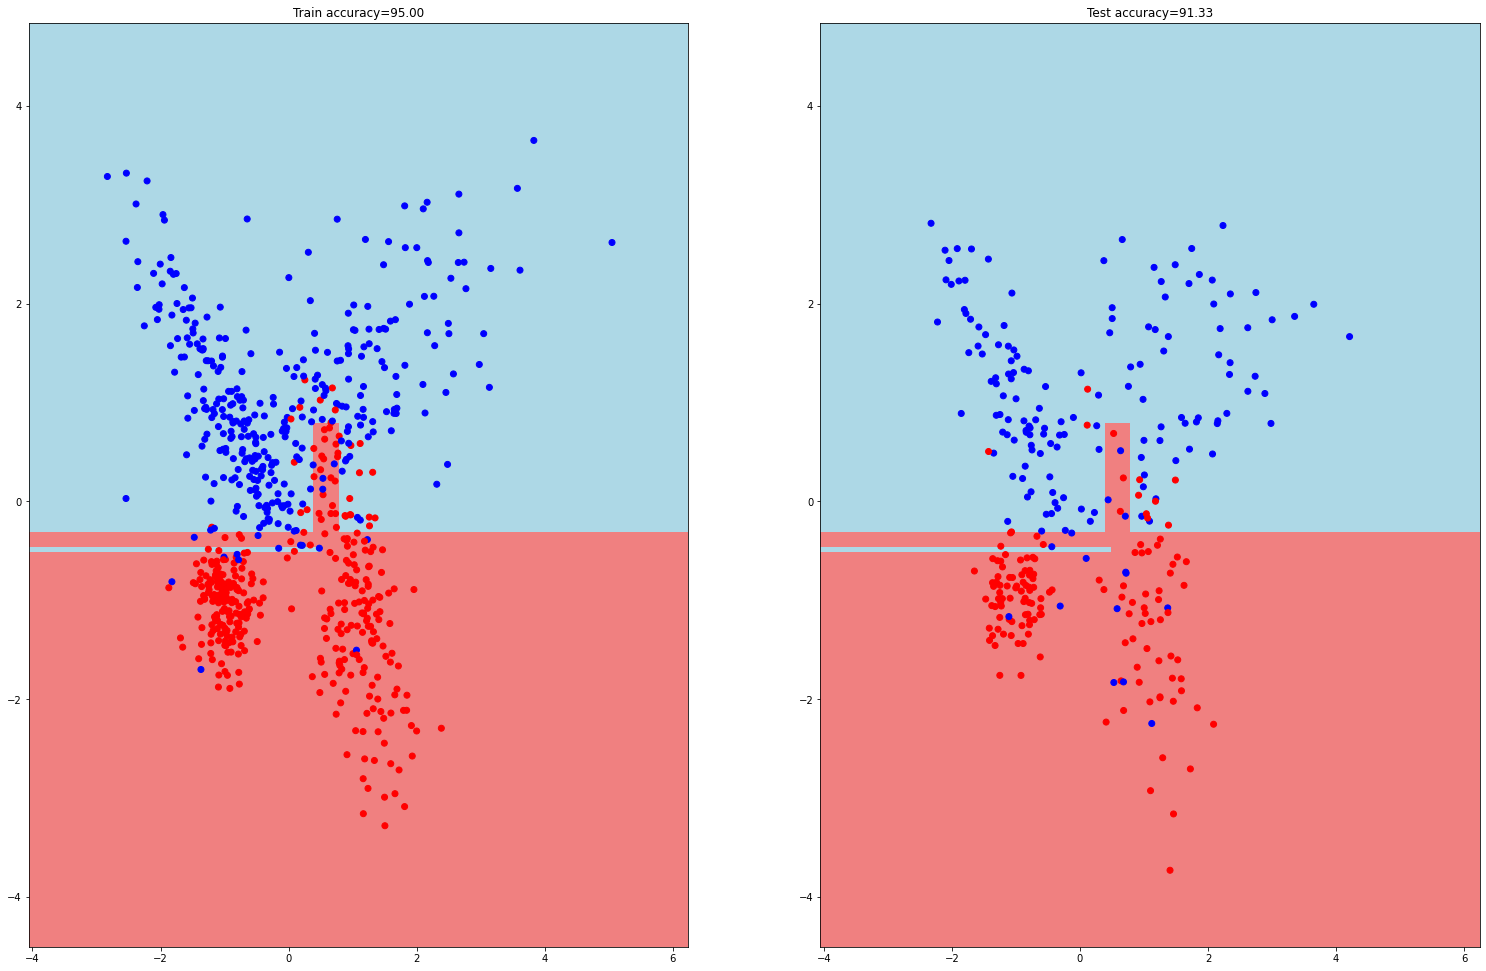

In [258]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (26, 17))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')
plt.rcParams['pcolor.shading'] ='nearest'

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')
plt.rcParams['pcolor.shading'] ='nearest'